# Sensitivity analysis of the critical head difference

In this example, we will demonstrate how to conduct a sensitivity analysis of the critical head difference model developed by Sellmeijer. This model is applicable to the piping failure mechanism, which addresses backward internal erosion beneath dikes with predominantly horizontal seepage paths.

### Define model

First, let's import the necessary packages:

In [21]:
from streams import SensitivityProject, DistributionType, SensitivityMethod
import numpy as np
import matplotlib.pyplot as plt

The critical head difference, $H_c$, according to the Sellmeijer's model is described by the following equations:

$F_{resistance}=\eta\cdot \frac{\gamma_{sub,particles}}{\gamma_{water}}\cdot \tan \theta_{sellmeijer,rev}$


$F_{scale}=\frac{d_{70.m}}{\sqrt[3]{\kappa\cdot L}}\cdot\left(\frac{d_{70}}{d_{70.m}}\right)^{0.4}$ and $\kappa = \frac{\nu_{water}}{g}\cdot k$


$F_{geometry}=0.91\cdot \left(\frac{D}{L}\right)^{\frac{0.28}{\left(\frac{D}{L}\right)^{2.8}-1}+0.04}$

$H_c = F_{resistance} \cdot F_{scale} \cdot F_{geometry} \cdot L$

where: <br>
$L$ - seepage length (m) <br>
$D$ - thickness of upper sand layer (m) <br>
$\theta$ - bedding angle ($\circ$) <br>
$d_{70}$ - particle diameter (m) <br>
$k$ - permeability of the upper sand layer (m/s)

In [22]:
def model_sellmeijer(k, L, d70, D):

    RD = 0.725
    RDm = 0.725
    d70m = 2.08e-4
    nu = 1.33e-6
    eta = 0.25
    theta = 37.0

    f_resistance = 1.65*eta*np.tan(theta/180*np.pi)*(RD/RDm)**0.35
    f_scale = d70m/(nu/9.81*k*L)**(1/3)*(d70/d70m)**0.39
    f_geometry = 0.91*(D/L)**(0.28/(((D/L)**2.8)-1)+0.04)

    if D==L:
        f_geometry = 1.0
    
    delta_h_c = f_resistance * f_scale * f_geometry * L

    return delta_h_c

### Sensitivity analysis

The goal is to estimate the effect of the input parameters $k$, $L$, $d_{70}$ and $D$ on the critical head difference. 
To achieve this, we conduct a sensitivity analysis, we begin by creating a sensitivity project and defining the model:

In [23]:
project = SensitivityProject()
project.model = model_sellmeijer

We define all the input parameters of the model as deterministic variables:

In [24]:
project.variables["k"].distribution = DistributionType.deterministic
project.variables["k"].mean = 0.000245598

project.variables["L"].distribution = DistributionType.deterministic
project.variables["L"].mean = 40.0

project.variables["d70"].distribution = DistributionType.deterministic
project.variables["d70"].mean = 0.00019

project.variables["D"].distribution = DistributionType.deterministic
project.variables["D"].mean = 30.0

### Crude Monte Carlo

The following code estimates the effect of each parameter on the critical head difference. Each parameter is assumed to follow a log-normal distribution, with the mean value as specified above and a standard deviation equal to 25% of the mean.

We use the `crude_monte_carlo` method and define the relevant settings: `minimum_samples` and `maximum_samples`.

The sensitivity analysis is performed using `project.run()`, and the results can be accessed from `project.stochast`.

In [25]:
project.settings.sensitivity_method = SensitivityMethod.crude_monte_carlo
project.settings.minimum_samples = 100
project.settings.maximum_samples = 200

for var in ["k", "L", "d70", "D"]:
        
        project.variables[var].distribution = DistributionType.log_normal
        project.variables[var].deviation = project.variables[var].mean*0.25
    
        project.run()
        sens = project.stochast
        
        print(f"Effect of {var}:( mean = {sens.mean}, std = {sens.deviation}, median = {sens.get_quantile(0.5)} )")
        
        project.variables[var].distribution = DistributionType.deterministic

Effect of k:( mean = 2.4019276265421916, std = 0.1945347947786058, median = 2.3877313179773205 )
Effect of L:( mean = 2.321004963350937, std = 0.4642433287202371, median = 2.2626004859523516 )
Effect of d70:( mean = 2.329505145238177, std = 0.23575661470502998, median = 2.29532402478645 )
Effect of D:( mean = 2.384997868315509, std = 0.08490030120560915, median = 2.3692996588643958 )


The results of the sensitivity analysis with `crude_monte_carlo` are presented in a `histogram`, which can be accessed as follows:

In [26]:
bin_start = [sens.histogram_values[ii].lower_bound for ii in range(0, len(sens.histogram_values))]
bin_end = [sens.histogram_values[ii].upper_bound for ii in range(0, len(sens.histogram_values))]
amount = [sens.histogram_values[ii].amount for ii in range(0, len(sens.histogram_values))]

We can also derive the corresponding probability density function using the `get_pdf()` method.

Text(0.5, 1.0, 'form')

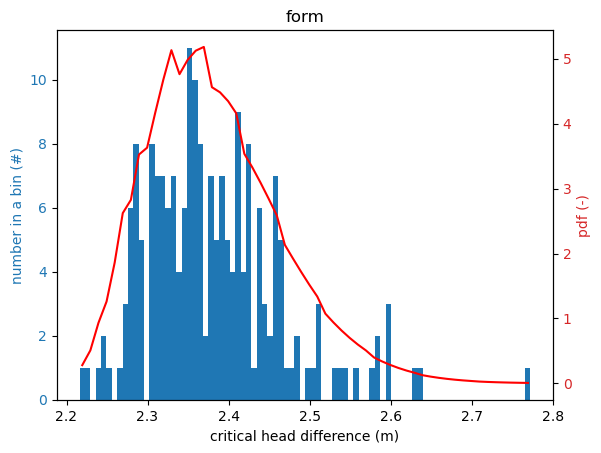

In [30]:
pdf_grid = np.arange(min(bin_start), max(bin_end), 0.01)
pdf = [sens.get_pdf(val) for val in pdf_grid]

fig, ax1 = plt.subplots()
color = "tab:blue"
ax1.set_xlabel("critical head difference (m)")
ax1.set_ylabel("number in a bin (#)", color=color)
ax1.bar(bin_start, amount, width=(np.array(bin_end)-np.array(bin_start)), label=var)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("pdf (-)", color=color)
ax2.plot(pdf_grid, pdf, "r", label="pdf")
ax2.tick_params(axis="y", labelcolor=color)
plt.title(project.settings.sensitivity_method)

### Other methods

Other available sensitivity methods include: `numerical_integration`, `fosm`, `form`, `importance_sampling`, and `directional_sampling`.

The results from `numerical_integration` and `importance_sampling` are displayed in a `histogram`. The results from `form` and `directional_sampling` are displayed in a `cdf_curve`. The results from `fosm` follow a `normal` distribution. The distribution type can be checked with `sens.distribution`.

The following code demonstrates the sensitivity analysis using `fosm`.

In [28]:
project.settings.sensitivity_method = SensitivityMethod.fosm

for var in ["k", "L", "d70", "D"]:
                
        project.variables[var].distribution = DistributionType.log_normal
        project.variables[var].deviation = project.variables[var].mean*0.25
        
        project.run()
        sens = project.stochast

        print(f"Effect of {var}:( mean = {sens.mean}, std = {sens.deviation}, median = {sens.get_quantile(0.5)} )")

        project.variables[var].distribution = DistributionType.deterministic

Effect of k:( mean = 2.3851618570590736, std = 0.20401638848709602, median = 2.3851618570590736 )
Effect of L:( mean = 2.30450201049311, std = 0.511695652618418, median = 2.30450201049311 )
Effect of d70:( mean = 2.333434185341425, std = 0.2351815920821294, median = 2.333434185341425 )
Effect of D:( mean = 2.3711273210279566, std = 0.09204013653525012, median = 2.3711273210279566 )


The following code demonstrates the sensitivity analysis using `form`.

Text(0.5, 1.0, 'form')

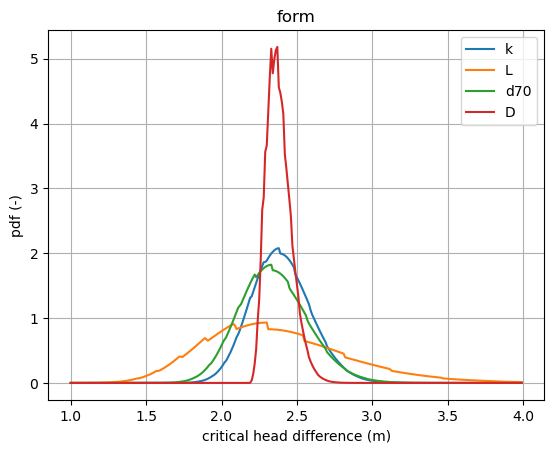

In [29]:
project.settings.sensitivity_method = SensitivityMethod.form

pdf_grid = np.arange(1.0, 4.0, 0.01)

plt.figure()
for var in ["k", "L", "d70", "D"]:
                
        project.variables[var].distribution = DistributionType.log_normal
        project.variables[var].deviation = project.variables[var].mean*0.25
        
        project.run()
        sens = project.stochast
        pdf = [sens.get_pdf(val) for val in pdf_grid]
        plt.plot(pdf_grid, pdf, label=var)
        project.variables[var].distribution = DistributionType.deterministic

plt.grid()
plt.xlabel("critical head difference (m)")
plt.ylabel("pdf (-)")
plt.legend()
plt.title(project.settings.sensitivity_method)